# <B><U> Automatic-Ticket-Classification-NLP - by Satya Prakash</U></B>

## Problem Statement 

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers. 

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base. 

In this case study, you will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as credit cards, banking and mortgages/loans. 

## Business goal

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue. 

With the help of non-negative matrix factorization (NMF), an approach under topic modelling, you will detect patterns and recurring words present in each ticket. This can be then used to understand the important features for each cluster of categories. By segregating the clusters, you will be able to identify the topics of the customer complaints.  

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

- Credit card / Prepaid card
- Bank account services
- Theft/Dispute reporting
- Mortgages/loans
- Others 

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Solution Approach

1. Data loading
2. Text preprocessing
3. Exploratory data analysis (EDA)
4. Feature extraction
5. Topic modelling
6. Model building using supervised learning
7. Model training and evaluation
8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_roc_curve
from pprint import pprint

In [3]:
# Import Textblob for extracting noun phrases
# !pip install textblob
from textblob import TextBlob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/626.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/626.3 kB ? eta -:--:--
   -- ------------------------------------ 41.0/626.3 kB 245.8 kB/s eta 0:00:03
   ------------------ --------------------- 286.7/626.3 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------  624.6/626.3 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 2.8 MB/s eta 0:00:00


In [4]:
# Installing wordcloud
# !pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
# Import pickle to save and load the model
import pickle

In [6]:
# import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in 'c:\\Users\\satya\\Desktop\\IIITB Upgrad\\Natural Language Processing\\Automatic Ticket Classification - Case Study': ['Automatic_Ticket_Classification_Assignment.ipynb', 'Automatic_Ticket_Classification_Assignment_Satya&Mythili.ipynb', 'complaints-2021-05-14_08_16.json']


In [9]:
#from google.colab import drive
#drive.mount('/content/drive')


In [10]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')
# Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)



## Data preparation

In [27]:
# Inspect the dataframe to understand the given data.

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [28]:
#print the column names
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [29]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [30]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [31]:
#Remove all rows where complaints column is nan
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [32]:
df.shape

(21072, 22)

In [33]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [34]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [35]:
# Convert Complaints column to string
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [36]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent)
    pattern = '\w*\d\w*' # Removing words with numbers in between
    sent = re.sub(pattern, '', sent)
    return sent

In [37]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [38]:
df_clean

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [39]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [42]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [43]:
#Write your function to extract the POS tags

# def pos_tag(text):
  # write your code here
def get_POS_tags(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)



In [44]:
# This column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean['complaint_POS_removed'] = df_clean['complaint_lemmatized'].apply(get_POS_tags)

In [45]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




c:\Users\satya\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



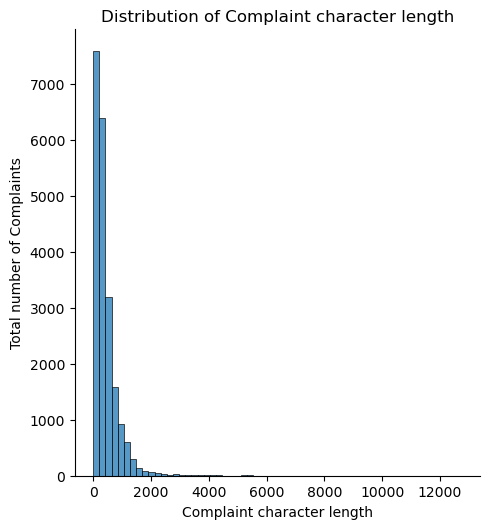

In [46]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

**Observation: ** Distribution is right skewed but it is normal distribution

#### Find the top 40 words by frequency among all the articles after processing the text.

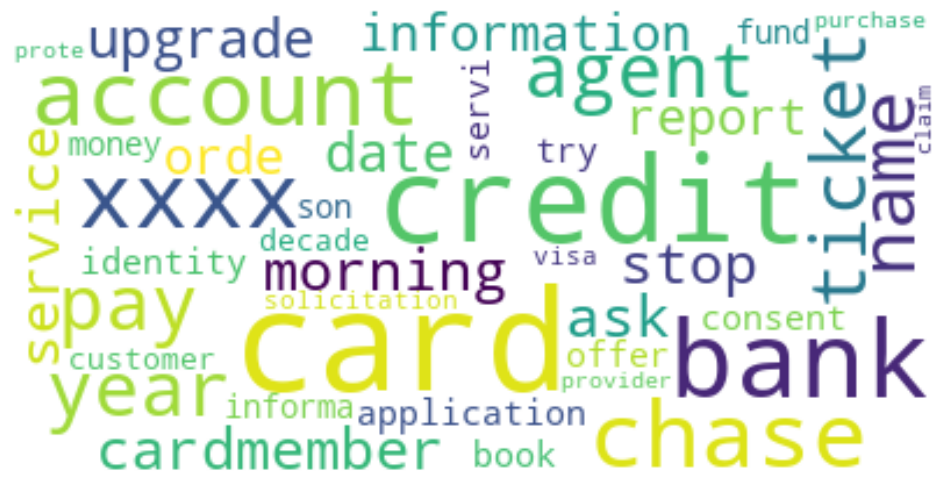

In [47]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40,
                      background_color="white", random_state=100,
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Top words observed from the word cloud are

card, credit, bank, account, chase, year etc.,

In [48]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [49]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [50]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47521
1,chase,46710
2,xxxx,36582
3,credit,34154
4,card,29289
5,bank,28410
6,payment,21170
7,time,16027
8,charge,14998
9,day,12977


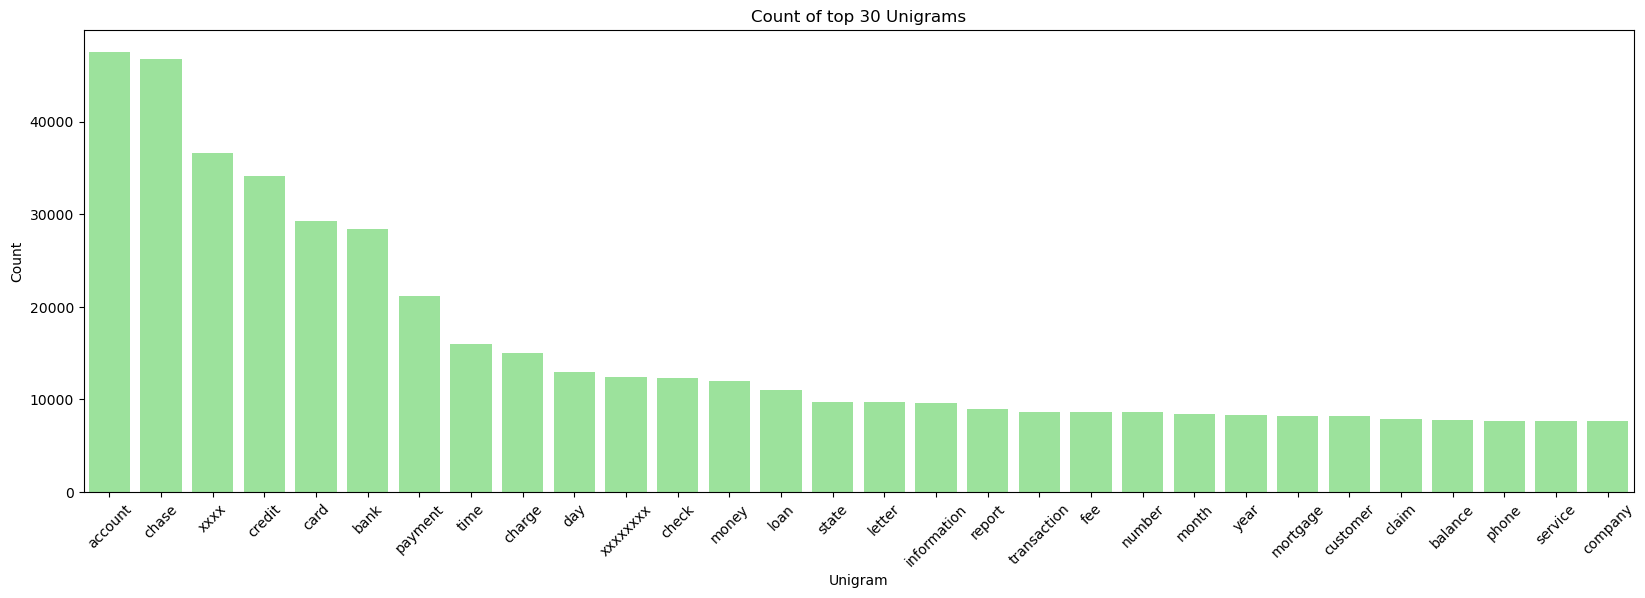

In [51]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [52]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12781
1,credit report,3955
2,xxxx xxxx,3953
3,customer service,3081
4,chase credit,2966
5,chase bank,2940
6,bank account,2728
7,account chase,2594
8,chase account,2564
9,check account,2414


In [53]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12781
1,credit report,3955
2,xxxx xxxx,3953
3,customer service,3081
4,chase credit,2966
5,chase bank,2940
6,bank account,2728
7,account chase,2594
8,chase account,2564
9,check account,2414


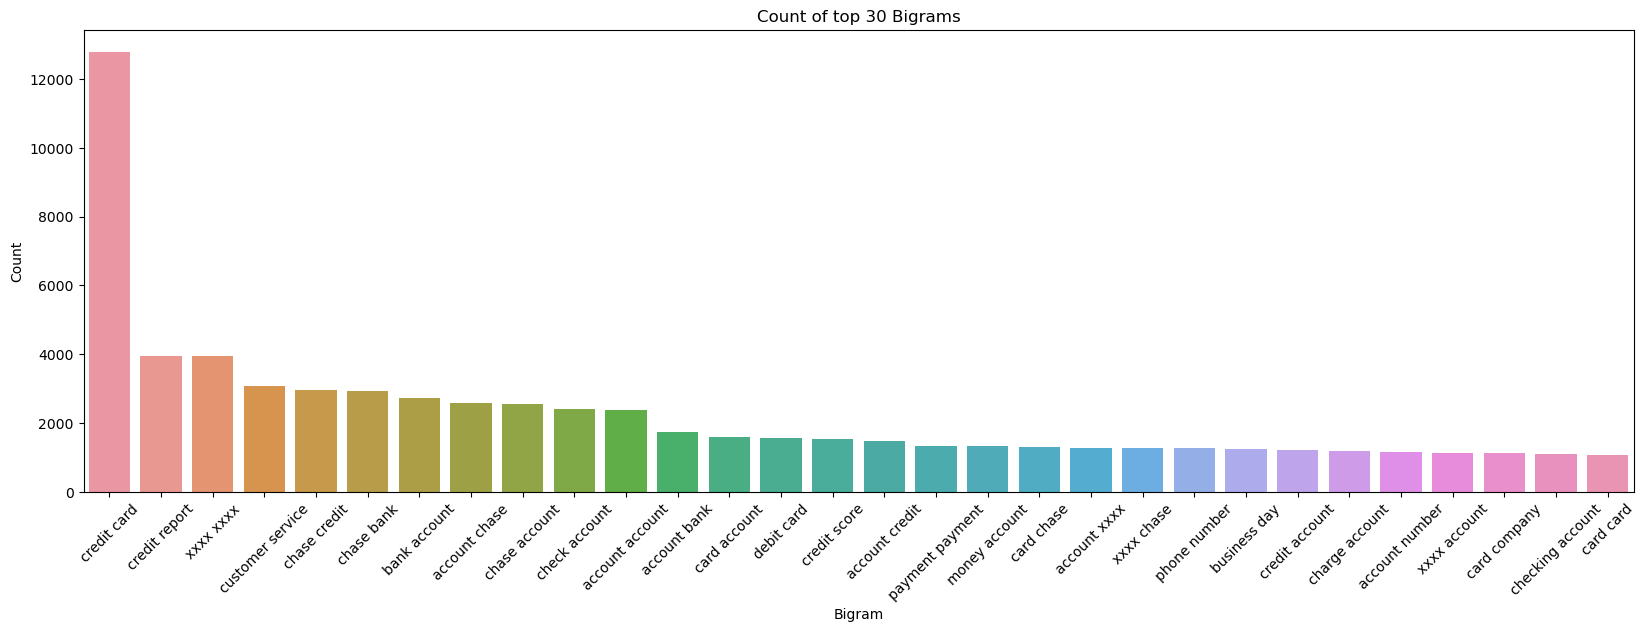

In [54]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [55]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,2063
1,credit card account,1023
2,credit card company,992
3,credit card chase,633
4,credit card credit,513
5,inquiry credit report,481
6,charge credit card,422
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,387


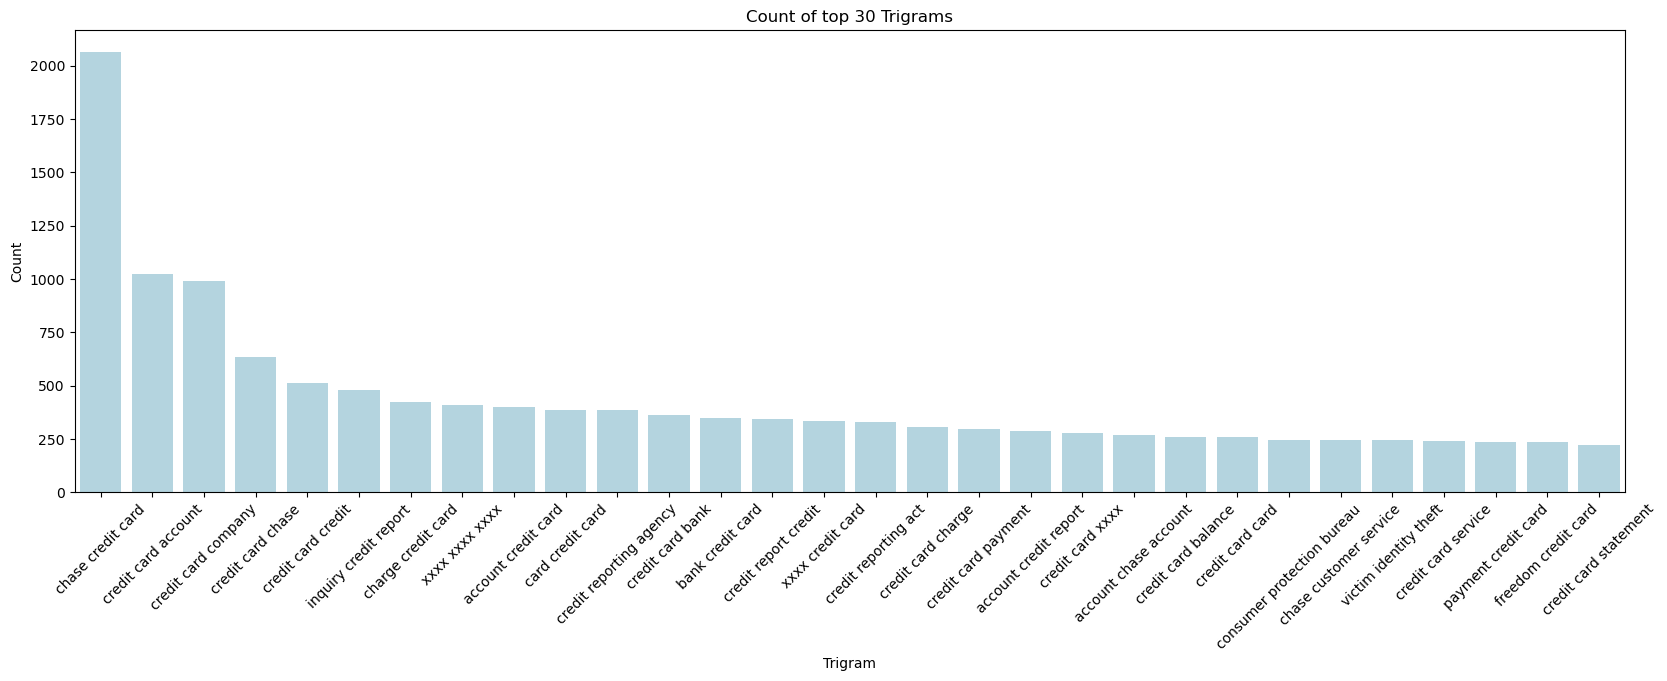

In [56]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'], color='lightblue')
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [57]:
#Print the top 10 words in the trigram
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1023
2,credit card company,992
3,credit card chase,633
4,credit card credit,513
5,inquiry credit report,481
6,charge credit card,422
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,387


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [58]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [59]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [60]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [61]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [62]:
dtm

<21072x7267 sparse matrix of type '<class 'numpy.float64'>'
	with 643788 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [63]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [64]:
#Load your nmf_model with the n_components i.e 5
#write the value you want to test out
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [65]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7267

In [66]:
H = nmf_model.components_       # Topic-term matrix

In [67]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


**Observation**
Looking at the topics above, for each topic, we can give a label based on their products/services:

- Topic 1 = Bank account services
- Topic 2 = Credit card / Prepaid card
- Topic 3 = Others
- Topic 4 = Theft/Dispute reporting
- Topic 5 = Mortgages/loans

In [68]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_results = nmf_model.transform(dtm)

In [69]:
#Assign the best topic to each of the cmplaints in Topic Column

#write your code to assign topics to each rows.
df_clean['Topic'] = topic_results.argmax(axis=1)

In [70]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [71]:
#Print the first 5 Complaint for each of the Topics
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')


,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [72]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }



In [73]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [74]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Others


In [75]:
df_clean.shape

(21072, 5)

In [76]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [77]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [78]:
df_clean.shape

(21072, 5)

In [79]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [80]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [81]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [82]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [83]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)


In [84]:
# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

**Logistic Regression**

In [85]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

# Getting the score of the base model
logreg.score(X_test, y_test)

0.914742170199304

With base Logistic Regression model, we get an accuracy of 91.47%

Tuning with Hyper parameters

In [86]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [87]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [88]:
# Check best parameters
logreg_hpt.best_params_

{'C': 5, 'solver': 'liblinear'}

In [89]:
# Evaluating the model after tuning
logreg_hpt.score(X_test, y_test)

0.9183802594115786

With the hyper parameter tuning of Logistic Regression model, we get an accuracy of 91.83% which is an improvement over the base model's accuracy of 91.47%

In [90]:
# Save Logistic Regression Model
pickle.dump(logreg_hpt, open("logreg_model.pk1", "wb"))

**Model Evaluation**

In [91]:
# Load pickled model
logreg_model = pickle.load(open("logreg_model.pk1", "rb"))

In [92]:
# Make predictions on test data
y_pred = logreg_model.predict(X_test)
# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[1472   27    6   44   19]
 [  26 1421   12   55    9]
 [  17   18  606   12   19]
 [  82   54    7 1287   27]
 [  29   30   11   12 1020]]


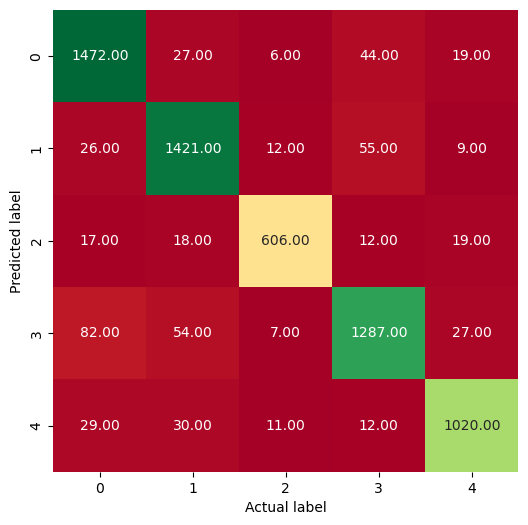

In [93]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.2f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [94]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [95]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.91      0.94      0.92      1568
Credit card / Prepaid card       0.92      0.93      0.92      1523
                    Others       0.94      0.90      0.92       672
   Theft/Dispute reporting       0.91      0.88      0.90      1457
           Mortgages/loans       0.93      0.93      0.93      1102

                  accuracy                           0.92      6322
                 macro avg       0.92      0.92      0.92      6322
              weighted avg       0.92      0.92      0.92      6322



The overall Accuracy, Precision and Recall of the Logistic Regression model is **92%** which makes this is a very good model.

**Decision Tree Classifier**

In [96]:
# Importing DecisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# Getting the score of the base model
dt.score(X_test, y_test)

0.7874258600237248

With base Decision Tree model, we get an accuracy of **78.74%**

**HyperParameter Tuning**

In [97]:
dt_grid = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [98]:
# Setup grid hyperparameter search for LogisticRegression
dt_hpt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                                param_grid=dt_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [99]:
# Check best parameters
dt_hpt.best_params_

{'max_depth': 10, 'min_samples_leaf': 13, 'min_samples_split': 2}

In [100]:
# Evaluating the tuned model
dt_hpt.score(X_test, y_test)

0.7691577698695137

With the tuned Decision Tree model, we get an accuracy of **76.92%** which is less than the base model's accuracy of **78.74%**

In [101]:
# Save Logistic Regression Model
pickle.dump(dt_hpt, open("dt_model.pk1", "wb"))

**Model Evaluation**

In [102]:
# Load pickled model
dt_model = pickle.load(open("dt_model.pk1", "rb"))

In [103]:
# Make predictions on test data
y_pred = dt_model.predict(X_test)

# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))


[[834  49  25  46  89]
 [ 27 835  19 101  65]
 [ 27  32 340  18  26]
 [138  85  24 605 117]
 [ 25  22  21  17 628]]


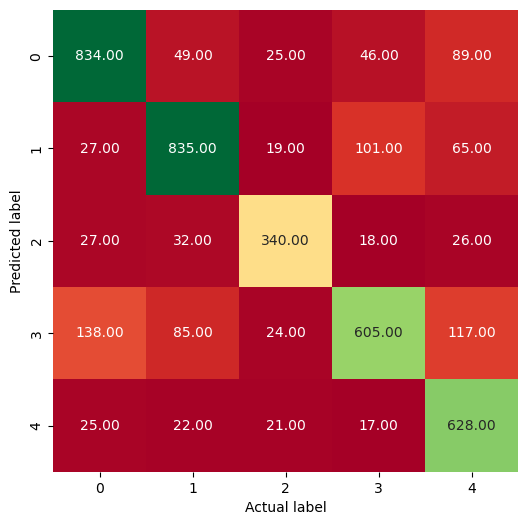

In [104]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.2f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [105]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [106]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.80      1043
Credit card / Prepaid card       0.82      0.80      0.81      1047
                    Others       0.79      0.77      0.78       443
   Theft/Dispute reporting       0.77      0.62      0.69       969
           Mortgages/loans       0.68      0.88      0.77       713

                  accuracy                           0.77      4215
                 macro avg       0.77      0.77      0.77      4215
              weighted avg       0.77      0.77      0.77      4215



- The overall Accuracy, Precision and Recall of the Decision Tree model is **77%**
- This is an okay model but much poor compared to Logistic Regression where the accuracy was 92%

**Random Forest Classifier**

In [107]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

# Getting the score of the base model
rf.score(X_test, y_test)

0.8175563463819692

With base Random Forest model, we get an accuracy of **81.75%**

**Tuning with HyperParameters**

In [108]:
rf_grid = {"n_estimators": np.arange(10, 700, 50),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [109]:
# Setup random hyperparameter search for LogisticRegression
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [110]:
# Check best parameters
rf_hpt.best_params_

{'n_estimators': 310,
 'min_samples_split': 18,
 'min_samples_leaf': 19,
 'max_depth': 10}

In [111]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7302491103202847

After Randomized Search, Random Forecast model accuracy is only 73.57%. Let's fine tune the results further based on Grid Search

In [112]:
rf_grid = {"n_estimators": [200, 260, 300],
           "max_depth": [7, 10, 15],
           "min_samples_split": [10, 12, 14],
           "min_samples_leaf": [6, 8, 10]}

In [113]:
# Setup grid hyperparameter search for LogisticRegression
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train, y_train);

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [114]:
# Check best parameters
rf_hpt.best_params_

{'max_depth': 15,
 'min_samples_leaf': 6,
 'min_samples_split': 14,
 'n_estimators': 300}

In [115]:
# Evaluating the tuned model
rf_hpt.score(X_test, y_test)

0.7539739027283511

After Grid Search, the Random Forest model has an accuracy of **75.4%.**

In [116]:
# Save Random Forest Model
pickle.dump(rf_hpt, open("rf_model.pk1", "wb"))

#### Model Evaluation

In [117]:
# Load pickled model
rf_model = pickle.load(open("rf_model.pk1", "rb"))

# Make predictions on test data
y_pred = rf_model.predict(X_test)

# Print Confusion Matrix
print(confusion_matrix(y_test, y_pred))

[[941  74   0  22   6]
 [ 48 914   0  80   5]
 [ 96 147  28  82  90]
 [138  97   1 728   5]
 [ 38  96   0  12 567]]


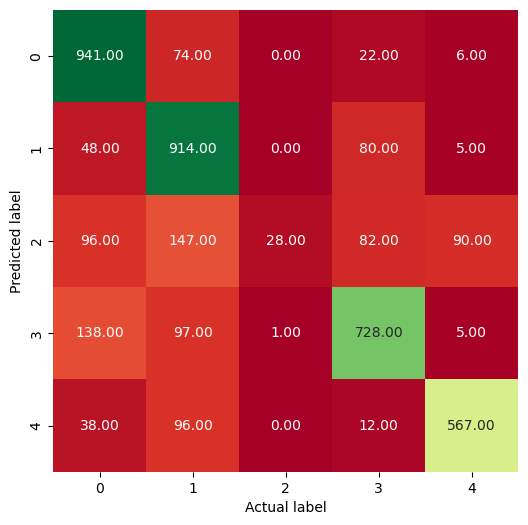

In [118]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.2f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.show()

In [119]:
Topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]


In [120]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = Topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.75      0.90      0.82      1043
Credit card / Prepaid card       0.69      0.87      0.77      1047
                    Others       0.97      0.06      0.12       443
   Theft/Dispute reporting       0.79      0.75      0.77       969
           Mortgages/loans       0.84      0.80      0.82       713

                  accuracy                           0.75      4215
                 macro avg       0.81      0.68      0.66      4215
              weighted avg       0.78      0.75      0.72      4215



- The overall accuracy of the Random Forest model is **75%**
- Precision and Accuracy are 81% and 68% respectively and we can see that the model overfits for "Others" category for Precision
- This is a very poor model as compared to Logistic Regression where the accuracy was 92%

## Overall Results

We created three supervised models (Logistic Regression, Decision Tree Classifier and Random Forest Classifier) to predict any new complaints to the relevant Topics.

**Results**

*Logistic Regression*
- The overall Accuracy, Precision and Recall of the Logistic Regression model is **92%**
- This is a very good model.

*Decision Tree*
- The overall Accuracy, Precision and Recall of the Decision Tree model is **77%**
- This is an okay model but much poor compared to Logistic Regression where the accuracy was 92%

*Random Forest*
- The overall accuracy of the Random Forest model is **75%**
- Precision and Recall are 81% and 68% respectively and we can see that the model overfits for "Others" category for Precision

## Conclusion

Based on the above results, Logistic Regression is the best model with an Accuracy, Precision and Recall as **92%** respectively